# Problem Statement

In this notebook we'll go over the process of analysing an A/B test, from formulating a hypothesis, testing it, and finally interpreting results. For our data, we'll use a dataset from Kaggle which contains the results of an A/B test on what seems to be 2 different designs of a website page (old_page vs. new_page). 

Steps to be taken:

Designing our experiment
Collecting and preparing the data
Visualising the results
Testing the hypothesis
Drawing conclusions
To make it a bit more realistic, here's a potential scenario for our study:

Let's imagine you work on the product team at a medium-sized online e-commerce business. The UX designer worked really hard on a new version of the product page, with the hope that it will lead to a higher conversion rate. The product manager (PM) told you that the current conversion rate is about 13% on average throughout the year, and that the team would be happy with an increase of 2%, meaning that the new design will be considered a success if it raises the conversion rate to 15%.

Before rolling out the change, the team would be more comfortable testing it on a small number of users to see how it performs, so you suggest running an A/B test on a subset of your user base users.

# Designing the Experiment


Formulating a hypothesis
First things first, we want to make sure we formulate a hypothesis at the start of our project. This will make sure our interpretation of the results is correct as well as rigorous.

Given we don't know if the new design will perform better or worse (or the same?) as our current design, we'll choose a **two-tailed test**:

H0 : p = p0

Ha : p != p0

where p and p0 stand for the conversion rate of the new and old design, respectively. We'll also set a confidence level of 95%: alpha (a) = .05

The alpha value is a threshold we set, by which we say "if the probability of observing a result as extreme or more (-value) is lower than , then we reject the null hypothesis". Since our alpha=.05  (indicating 5% probability), our confidence (1 - alpha) is 95%.

Don't worry if you are not familiar with the above, all this really means is that whatever conversion rate we observe for our new design in our test, we want to be 95% confident it is statistically different from the conversion rate of our old design, before we decide to reject the Null hypothesis .

Choosing the variables
For our test we'll need two groups:

A control group - They'll be shown the old design

A treatment (or experimental) group - They'll be shown the new design

This will be our Independent Variable. The reason we have two groups even though we know the baseline conversion rate is that we want to control for other variables that could have an effect on our results, such as seasonality: by having a control group we can directly compare their results to the treatment group, because the only systematic difference between the groups is the design of the product page, and we can therefore attribute any differences in results to the designs.

For our Dependent Variable (i.e. what we are trying to measure), we are interested in capturing the conversion rate. A way we can code this is by each user session with a binary variable:

**0 - The user did not buy the product during this user session**

**1 - The user bought the product during this user session**

This way, we can easily calculate the mean for each group to get the conversion rate of each design.

**Choosing a sample size**
It is important to note that since we won't test the whole user base (our population), the conversion rates that we'll get will inevitably be only estimates of the true rates.

The number of people (or user sessions) we decide to capture in each group will have an effect on the precision of our estimated conversion rates: the larger the sample size, the more precise our estimates (i.e. the smaller our confidence intervals), the higher the chance to detect a difference in the two groups, if present.

On the other hand, the larger our sample gets, the more expensive (and impractical) our study becomes.

So how many people should we have in each group?

The sample size we need is estimated through something called *Power analysis*, and it depends on a few factors:

**Power of the test (1- Beta)** - This represents the probability of finding a statistical difference between the groups in our test when a difference is actually present. This is usually set at 0.8 as a convention (here's more info on statistical power, if you are curious)

**Alpha value (alpha)** - The critical value we set earlier to 0.05

**Effect size** - How big of a difference we expect there to be between the conversion rates

Since our team would be happy with a difference of 2%, we can use 13% and 15% to calculate the effect size we expect.

# Loading Packages

In [57]:
library(tidyverse)
library(lubridate)
library(broom)
library(caret)

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress




# Preparing the Data

In [1]:
ab <- read.csv('../input/ab-testing/ab_data.csv')

head(ab)

,user_id,timestamp,group,landing_page,converted
,<int>,<chr>,<chr>,<chr>,<int>
1,851104,2017-01-21 22:11:48.556739,control,old_page,0
2,804228,2017-01-12 08:01:45.159739,control,old_page,0
3,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
4,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
5,864975,2017-01-21 01:52:26.210827,control,old_page,1
6,936923,2017-01-10 15:20:49.083499,control,old_page,0


**The timestamp column is in character format so we modifiy the column to be date for easier analysis**

In [2]:
ab$timestamp <- as.POSIXct(ab$timestamp,tz=Sys.timezone())

ab$timestamp <- format(as.POSIXct(ab$timestamp,format='%m/%d/%Y %H:%M:%S'),format='%m/%d/%Y')

ab$timestamp <- as.Date(ab$timestamp, "%m/%d/%Y")


In [3]:
head(ab)

,user_id,timestamp,group,landing_page,converted
,<int>,<date>,<chr>,<chr>,<int>
1,851104,2017-01-21,control,old_page,0
2,804228,2017-01-12,control,old_page,0
3,661590,2017-01-11,treatment,new_page,0
4,853541,2017-01-08,treatment,new_page,0
5,864975,2017-01-21,control,old_page,1
6,936923,2017-01-10,control,old_page,0


In [18]:
cross_tab <- ab %>% select(c(group,landing_page,))

table(cross_tab)

           landing_page
group       new_page old_page
  control       1928   145274
  treatment   145311     1965

There are 294478 rows in the DataFrame, each representing a user session, as well as 5 columns :

**user_id** - The user ID of each session

**timestamp** - Timestamp for the session

**group** - Which group the user was assigned to for that session {control, treatment}

**landing_page** - Which design each user saw on that session {old_page, new_page}

**converted** - Whether the session ended in a conversion or not (binary, 0=not converted, 1=converted)

# Power Analysis 

In [ ]:
total_sample_size <- SSizeLogisticBin(p1 = 0.13,
                                      p2 = 0.15,
                                      B = 0.5,
                                      alpha = 0.05,
                                      power = 0.8)
total_sample_size

Number is **4720** for each using R studio since powerMediation package to use the above code is not usable in Kaggle

**We split the data into Control data and Treatment data based on group column and then we join the data set as one**

In [31]:
control <- ab %>% filter(group == 'control')

treatment<- ab %>% filter(group == 'treatment')

ab_test <- rbind(control,treatment)

head(ab_test)

,user_id,timestamp,group,landing_page,converted
,<int>,<date>,<chr>,<chr>,<int>
1,851104,2017-01-21,control,old_page,0
2,804228,2017-01-12,control,old_page,0
3,864975,2017-01-21,control,old_page,1
4,936923,2017-01-10,control,old_page,0
5,719014,2017-01-17,control,old_page,0
6,644214,2017-01-22,control,old_page,1


**Calculating conversion rates for each day based on Control and Treatment pages**

In [34]:
ab_1 <- ab_test %>% group_by(timestamp,group)%>%
       summarize(conversion_rate=mean(converted))

head(ab_1)

`summarise()` has grouped output by 'timestamp'. You can override using the
`.groups` argument.


timestamp,group,conversion_rate
<date>,<chr>,<dbl>
2017-01-02,control,0.1250864
2017-01-02,treatment,0.1204569
2017-01-03,control,0.1137044
2017-01-03,treatment,0.1135618
2017-01-04,control,0.1217130
2017-01-04,treatment,0.1166088


# Visualizing daily Conversions

**Conversions for the month are almost identical for both Control and Treatment pages based on plot below**

In [ ]:
ggplot(ab_1 ,aes(x=timestamp,
                y=conversion_rate,
                color =group,
                group = group))+ 
        geom_point() +
        geom_line()

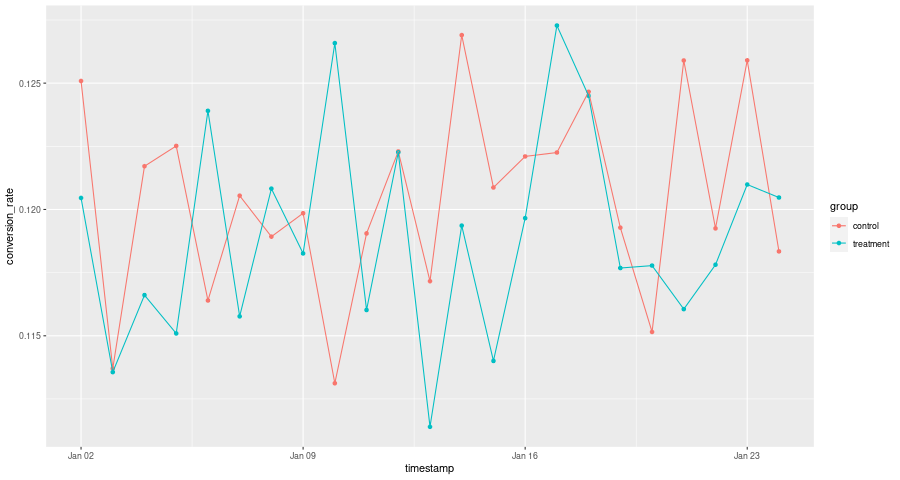

**Below we calculate the mean Conversion rates for Control and Treatment pages in one dataframe**

**Results show that treament has slightly lower conversions than Control data which is contrary to our expectations since we wanted Treatment page to have higher conversions compared to Control page**

In [46]:
ab_2 <- ab_1%>%
  group_by(group) %>%
  summarize(conversion_rate = mean(conversion_rate))

ab_2

group,conversion_rate
<chr>,<dbl>
control,0.1204773
treatment,0.1189709


**Visualizing Mean Conversion Rates**

In [ ]:
p<-ggplot(data=ab_2, aes(x=group, y=conversion_rate,color=group)) +
  geom_bar(stat="identity")+
  geom_text(aes(label=conversion_rate), vjust=1.6, color="white", size=3.5)+
  theme_minimal()

p

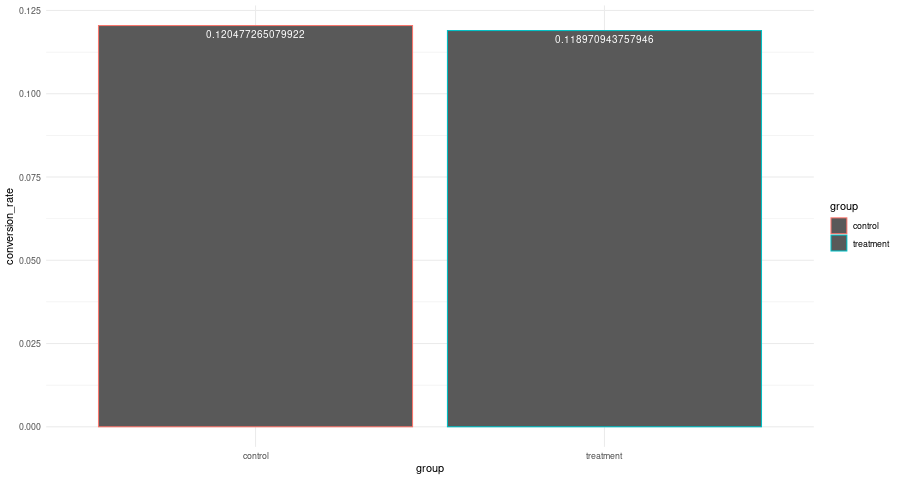

**The conversion rates for our groups are indeed very close. Also note that the conversion rate of the treatment group is lower than what we would have expected given what we knew about our avg. conversion rate (12.3% vs. 13%). This goes to show that there is some variation in results when sampling from a population.**

**So... the treatment group's value is lower. Is this difference statistically significant?**


#  Testing the hypothesis

In [60]:
experiment_results <- glm(converted ~ group,
                          family = "binomial",
                          data = ab_test)

summary(experiment_results)


Call:
glm(formula = converted ~ group, family = "binomial", data = ab_test)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-0.5065  -0.5065  -0.5032  -0.5032   2.0636  

Coefficients:
                Estimate Std. Error  z value Pr(>|z|)    
(Intercept)    -1.988655   0.008009 -248.299   <2e-16 ***
grouptreatment -0.014046   0.011356   -1.237    0.216    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 215702  on 294477  degrees of freedom
Residual deviance: 215701  on 294476  degrees of freedom
AIC: 215705

Number of Fisher Scoring iterations: 4


In [63]:
experiment_results %>% tidy()

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),-1.98865547,0.008009129,-248.298579,0.0000000
grouptreatment,-0.01404597,0.011355552,-1.236925,0.2161149


In [62]:
confint(experiment_results)

Waiting for profiling to be done...



,2.5 %,97.5 %
(Intercept),-2.00438452,-1.972988886
grouptreatment,-0.03630317,0.008210468


Since our -value=0.21 is way above our =0.05, we cannot reject the null hypothesis , which means that our new design did not perform significantly different than our old one :(

Additionally, if we look at the confidence interval for the treatment group ([0.03, 0.008], i.e. 3.6%-0.8%) we notice that:

It does not include our baseline value of 13% conversion rate

It does not include our target value of 15% (the 2% uplift we were aiming for)

What this means is that it is more likely that the true conversion rate of the new design is similar to our baseline, rather than the 15% target we had hoped for. This is further proof that our new design is not likely to be an improvement on our old design, and that unfortunately we are back to the drawing board!

In [26]:

# If we take the sampling route

#set.seed(10)

#control_sample <- sample(control,4720, replace = TRUE)

#treatment_sample <- sample(treatment,4720, replace = TRUE)